# Background 

    Starting from any random Wikipedia page, following the first* page link of the current page will eventually lead you to the "Philosophy" page of Wikipedia (~95% of the time).
     
    * Due to the structure of Wikipedia articles, the first valid link must NOT:
        
        be in either parentheses (usually language pages) or italics (usually disambiguations)
        
        be a link to either a meta page, a page outside Wikipedia, or a broken link
        
        be an in-page citation
        
        
        

## Basic Goal

    Make a webcrawler that starts from a random Wikipedia page, and follows the first page link until it either finds the Philosophy page, a page with no links, or loops back to a previously visited link.
    
    Return the name of the starting page, and the degrees of separation from the Philosophy page (set degree to -1 if terminates otherwise)

        Ex. the page "Kevin Bacon" should have a degree of separation of 12
        
    NOTE: For crawling, use either the Wikipedia API or 
    
    
    You can start from a random Wikipedia page with a URL (https://en.wikipedia.org/wiki/Special:Random)   
    
   

## Tips

 
        
    Use a while-loop for the crawling, but add a maximum search number if you're still debugging it
    
    When searching for links, you're always looking at the main text of the page (use the HTML structure)
        
        
        
        

## Advanced Goals

    1.) Get the degrees of separation for 1000 random pages. Find the median degree of separation as well as the distribution.
    
    2.) Considering your results, and the size of the English Wikipedia, estimate how many pages there are of degree 6.
    
    3.) Try the Cebuano Wikipedia. Following the same rules above, determine the network structure. 
    Is there is a page that all others tend to lead back to? 
    Does it tend to loop more? 
    In any case, are the degrees generally shorter/longer?
        

In [1]:
import ast
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Tuple, List
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

# Wikipedia Crawler

## Implementation for Single Link

In [2]:
def find_philosophy(
        start_url: str = "https://en.wikipedia.org/wiki/Special:Random",
        target_url: str = "https://en.wikipedia.org/wiki/Philosophy",
) -> Tuple[str, str, int, int]:
    
	next_url = start_url
	last_url = next_url
	visited_urls = set()
	degrees = 0
	href_count = 0 
	
	try:
		options = webdriver.ChromeOptions()
		options.add_argument("--headless")
		path = "/usr/local/bin/chromedriver"
		chrome_service = webdriver.ChromeService(executable_path=path)
		driver = webdriver.Chrome(service=chrome_service, options=options)
		driver.get(start_url)
		starting_title = driver.title
		
		while True:
			if next_url in visited_urls:
				degrees = -1
				last_url = next_url
				print("Loop detected!")
				break
			if next_url == target_url:
				print("Philosophy has been reached!")
				break
			visited_urls.add(next_url)
			driver.get(next_url)
			try:
				main_content = driver.find_element("id", "mw-content-text")
				links = main_content.find_elements(By.CSS_SELECTOR, "div.mw-parser-output > p a")
				found_valid_link = False
				for link in links[:5]:
					href = link.get_attribute("href")
					if (
						href and "/wiki" in href and
						":" not in href.split("/wiki/")[-1] and
						"cite_note" not in href
					):
						next_url = href
						found_valid_link = True
						degrees += 1
						href_count += 1
						break
				if not found_valid_link:
					degrees = -2
					print("Invalid link!")
					break
			except NoSuchElementException:
				degrees = -3
				break
			time.sleep(0.5)
	finally:
		driver.quit()
	return (starting_title, last_url, degrees, href_count)

In [3]:
results = find_philosophy(start_url="https://en.wikipedia.org/wiki/Special:Random")
results

Philosophy has been reached!


('Jesu, meines Glaubens Zier - Wikipedia',
 'https://en.wikipedia.org/wiki/Special:Random',
 16,
 16)

## Implementation for 1000 Pages
- Concurrent implementation is in `scraping_en_wiki_parallel.py`

In [9]:
results = []

for i in range(2):
    if i % 10 == 0:
        print(f"Processing page {i}/1000...")
    result = find_philosophy()
    results.append(result)

Processing page 0/1000...
Philosophy has been reached!
Philosophy has been reached!


In [10]:
results

[('Huichahue River - Wikipedia',
  'https://en.wikipedia.org/wiki/Special:Random',
  16,
  16),
 ('Frea albovittata - Wikipedia',
  'https://en.wikipedia.org/wiki/Special:Random',
  15,
  15)]

In [11]:
pd.DataFrame(results, columns=["starting_url", "link_tree", "degrees", "href_count"])

,starting_url,link_tree,degrees,href_count
0,Huichahue River - Wikipedia,https://en.wikipedia.org/wiki/Special:Random,16,16
1,Frea albovittata - Wikipedia,https://en.wikipedia.org/wiki/Special:Random,15,15


# Analysis of Network Structure

In [12]:
df_en = pd.read_csv("en_philosophy_results_20241028-224524.csv")
df_en["language"] = "English"

df_ceb = pd.read_csv("ceb_philosophy_results_20241028-233602.csv")
df_ceb["language"] = "Cebuano"

df = pd.concat([df_en, df_ceb]).reset_index().drop("index", axis=1)
df.head()

,starting_url,link_tree,degrees,href_count,language
0,2018–19 EBU Player of the Year Championship - ...,[[]],-2,0,English
1,Reza Zuhro - Wikipedia,[['https://en.wikipedia.org/wiki/Civil_parishe...,-2,3,English
2,Nanzih Technology Industrial Park metro statio...,[['https://en.wikipedia.org/wiki/New_Testament...,-1,6,English
3,Jake Duncombe - Wikipedia,[['https://en.wikipedia.org/wiki/Tiffany_Darwi...,13,13,English
4,Drew Von Bergen - Wikipedia,[['https://en.wikipedia.org/wiki/Sports_games'...,12,12,English


In [13]:
termination_dict = {
    -1: "loop",
    -2: "invalid_link",
    -3: "no_element"
}

df["termination_reason"] = df["degrees"].map(termination_dict).fillna("reached_philosophy")
df["terminal_link"] = df["link_tree"].apply(ast.literal_eval).str[-1].apply(lambda x: str(x).strip("[]|''"))
df

,starting_url,link_tree,degrees,href_count,language,termination_reason,terminal_link
0,2018–19 EBU Player of the Year Championship - ...,[[]],-2,0,English,invalid_link,
1,Reza Zuhro - Wikipedia,[['https://en.wikipedia.org/wiki/Civil_parishe...,-2,3,English,invalid_link,
2,Nanzih Technology Industrial Park metro statio...,[['https://en.wikipedia.org/wiki/New_Testament...,-1,6,English,loop,https://en.wikipedia.org/wiki/Hebrew_language
3,Jake Duncombe - Wikipedia,[['https://en.wikipedia.org/wiki/Tiffany_Darwi...,13,13,English,reached_philosophy,https://en.wikipedia.org/wiki/Philosophy
4,Drew Von Bergen - Wikipedia,[['https://en.wikipedia.org/wiki/Sports_games'...,12,12,English,reached_philosophy,https://en.wikipedia.org/wiki/Philosophy
...,...,...,...,...,...,...,...
1995,Kūh-e Āb Malakhī - Wikipedia,[['https://ceb.wikipedia.org/wiki/Tinipong_Ban...,-1,6,Cebuano,loop,https://ceb.wikipedia.org/wiki/Inglatera
1996,Lycaena venus - Wikipedia,"[['https://ceb.wikipedia.org/wiki/Lungsod'], [...",-1,6,Cebuano,loop,https://ceb.wikipedia.org/wiki/Kinatsila
1997,Navedalen - Wikipedia,"[['https://ceb.wikipedia.org/wiki/Insekto'], [...",-1,18,Cebuano,loop,https://ceb.wikipedia.org/wiki/Pransiya
1998,Donald King 1 Dam - Wikipedia,[['https://ceb.wikipedia.org/wiki/Dawhilahila'...,-1,18,Cebuano,loop,https://ceb.wikipedia.org/wiki/Pransiya


## English Wikipedia

In [14]:
total_wiki_pages = 6902357 # according to Wikipedia

cond = ((~df["degrees"].isin(list(termination_dict.keys()))) & (df["language"]=="English"))
en_valid_degrees = df[cond]["degrees"]
en_median_degree = en_valid_degrees.median()
en_degree_distribution = en_valid_degrees.value_counts().sort_index()

cond = ((df["degrees"]==6) & (df["language"]=="English"))
en_degree_6_count = len(df[cond])

cond = (df["language"]=="English")
en_degree_6_percentage = (en_degree_6_count / len(df[cond])) * 100

en_estimated_degree_6_total = int((en_degree_6_percentage / 100) * total_wiki_pages)

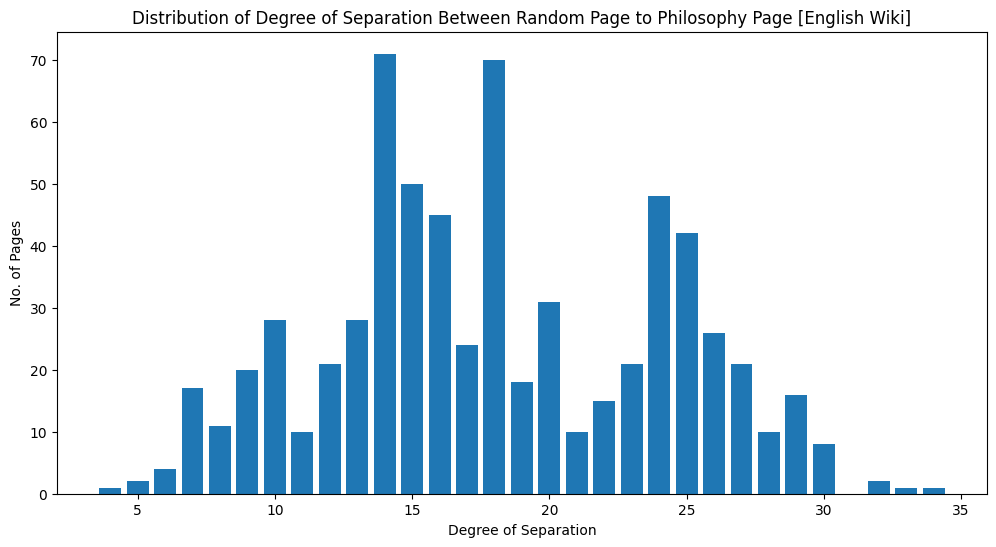

In [15]:
plt.figure(figsize=(12, 6))
plt.bar(en_degree_distribution.index, en_degree_distribution.values)
plt.title("Distribution of Degree of Separation Between Random Page to Philosophy Page [English Wiki]")
plt.xlabel("Degree of Separation")
plt.ylabel("No. of Pages")
plt.show()

In [16]:
print(f"Median degree of separation: {en_median_degree}")
print(f"\nPages with degree 6 in sample: {en_degree_6_count} ({en_degree_6_percentage:.2f}%)")
print(f"\nEstimated total Wikipedia pages with degree 6: {en_estimated_degree_6_total:,}")

Median degree of separation: 18.0

Pages with degree 6 in sample: 4 (0.40%)

Estimated total Wikipedia pages with degree 6: 27,609


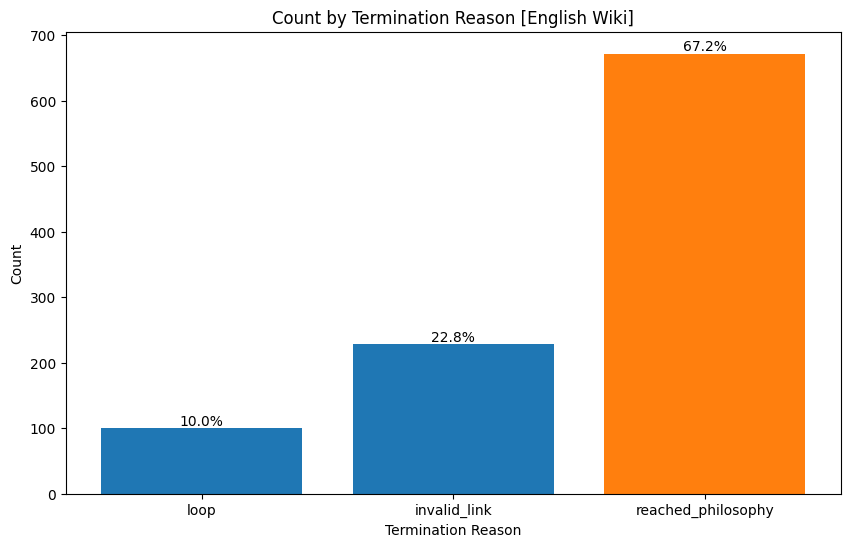

In [17]:
termination_df = df[cond]["termination_reason"].value_counts().sort_values()
total = termination_df.sum()

sns_orange = sns.color_palette()[1]

plt.figure(figsize=(10, 6))
colors = ['#1f77b4' if x != "reached_philosophy" else sns_orange for x in termination_df.index]
bars = plt.bar(termination_df.index, termination_df.values, color=colors)

for bar in bars:
    height = bar.get_height()
    percentage = (height/total) * 100
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{percentage:.1f}%", ha="center", va="bottom")

plt.title("Count by Termination Reason [English Wiki]")
plt.xlabel("Termination Reason")
plt.ylabel("Count")
plt.show()

## Cebuano Wikipedia

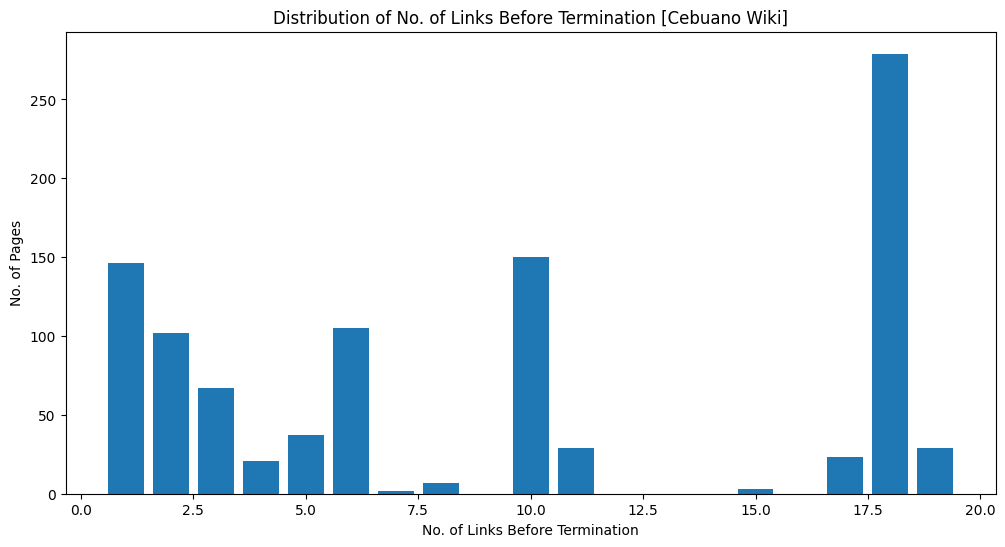

In [18]:
cond = (df["language"]=="Cebuano")
ceb_valid_degrees = df[cond]["href_count"]
ceb_median_degree = ceb_valid_degrees.median()
ceb_degree_distribution = ceb_valid_degrees.value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(ceb_degree_distribution.index, ceb_degree_distribution.values)
plt.title("Distribution of No. of Links Before Termination [Cebuano Wiki]")
plt.xlabel("No. of Links Before Termination")
plt.ylabel("No. of Pages")
plt.show()

In [19]:
ceb_top_loop = df[cond]["terminal_link"].value_counts().index[0]
ceb_avg_degree_distribution = df["href_count"].mean()
ceb_median_degree_distribution = df["href_count"].median()

In [20]:
print(f"Top page where others lead back to: {ceb_top_loop}")
print(f"\nAverage no. of links before termination: {ceb_avg_degree_distribution}")
print(f"\nMedian no. of links before termination: {ceb_median_degree_distribution}")

Top page where others lead back to: https://ceb.wikipedia.org/wiki/Pransiya

Average no. of links before termination: 11.569

Median no. of links before termination: 10.0


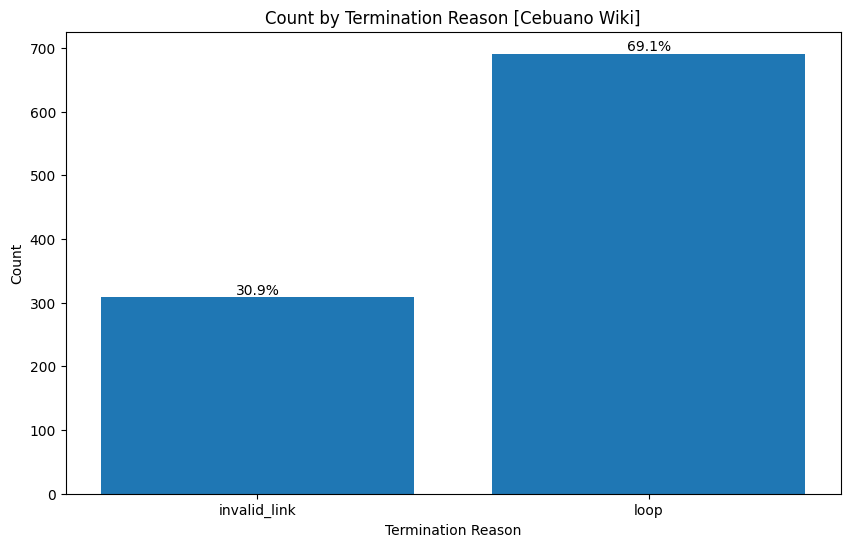

In [21]:
termination_df = df[cond]["termination_reason"].value_counts().sort_values()
total = termination_df.sum()

plt.figure(figsize=(10, 6))
bars = plt.bar(termination_df.index, termination_df.values, color=colors)

for bar in bars:
    height = bar.get_height()
    percentage = (height/total) * 100
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{percentage:.1f}%", ha="center", va="bottom")
plt.title("Count by Termination Reason [Cebuano Wiki]")
plt.xlabel("Termination Reason")
plt.ylabel("Count")
plt.show()

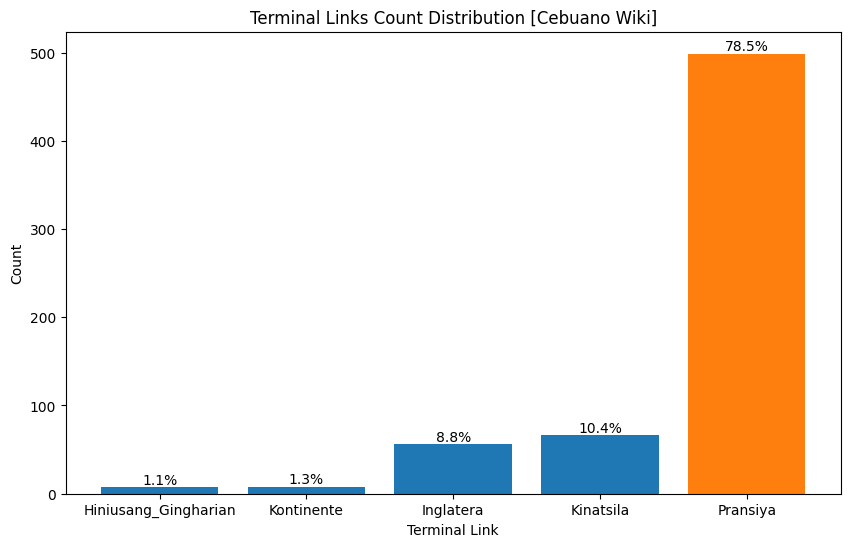

In [22]:
terminal_link = df[cond & (df["termination_reason"]=="loop")].groupby("terminal_link").starting_url.count().sort_values().tail(5)

labels = terminal_link.index.str.split("wiki/").str[1]
values = terminal_link.values

plt.figure(figsize=(10, 6))
colors = ["#1f77b4" if x != "Pransiya" else sns_orange for x in labels]

bars = plt.bar(range(len(values)), values, color=colors)

total = values.sum()
for bar in bars:
   height = bar.get_height()
   percentage = (height/total) * 100
   plt.text(bar.get_x() + bar.get_width()/2, height,
            f"{percentage:.1f}%",
            ha="center", va="bottom")

plt.xticks(range(len(labels)), labels, )
plt.title("Terminal Links Count Distribution [Cebuano Wiki]")
plt.xlabel("Terminal Link")
plt.ylabel("Count")

plt.show()